In [1]:
import sys
sys.path.append("/usr/local/python-env/py39/lib/python3.9/site-packages")

import pyspark
print(pyspark.__version__)

print(sys.executable)

3.5.0
/bin/python3.9


In [2]:
import os

os.environ['PYSPARK_PYTHON'] = '/usr/bin/python3.9'

In [3]:
import pkg_resources

sedona_version = pkg_resources.get_distribution("apache-sedona").version
print(f"Apache Sedona version: {sedona_version}")

Apache Sedona version: 1.5.1


In [4]:
print(os.environ['SPARK_HOME'])
print(os.environ['PYSPARK_PYTHON'])

/usr/local/spark/latest
/usr/bin/python3.9


In [5]:
from pyspark.sql import SparkSession
from sedona.register import SedonaRegistrator
from sedona.utils import SedonaKryoRegistrator, KryoSerializer
from pyspark.sql.functions import col
from pyspark.sql import functions as F


In [6]:
spark = SparkSession \
    .builder \
    .appName("GraphFramesExample") \
    .master('spark://hartford:30196') \
    .config("spark.jars.packages", "graphframes:graphframes:0.8.3-spark3.4-s_2.12") \
    .config("spark.yarn.resourcemanager.address", "columbia.cs.colostate.edu:30799") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")
logger = spark._jvm.org.apache.log4j.LogManager.getLogger(__name__)


:: loading settings :: url = jar:file:/usr/local/spark/3.5.0-with-hadoop3.3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /s/chopin/l/grad/ebmartin/.ivy2/cache
The jars for the packages stored in: /s/chopin/l/grad/ebmartin/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-8f6d1789-e739-41ca-8497-73e23b826bda;1.0
	confs: [default]
	found graphframes#graphframes;0.8.3-spark3.4-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 64ms :: artifacts dl 2ms
	:: modules in use:
	graphframes#graphframes;0.8.3-spark3.4-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	--------

In [7]:
# Import the necessary module from py4j to interact with JVM
from py4j.java_gateway import java_import

# Import the Path class from Hadoop. This class is used to handle file paths in Hadoop.
java_import(spark._jvm, 'org.apache.hadoop.fs.Path')

fs = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration())

In [7]:
def get_csv_df(file_name: str):
    data_directory = "hdfs://hartford.cs.colostate.edu:30181/geospatial/input/knowledge_graphs/"
    print(f"Processing file: {file_name}")

    if "Nodes" in file_name:
        schema = "Node_ID string, Type string"
        df = spark.read.format("csv").option("header", "true").schema(schema).load(data_directory + file_name)
        df = df.withColumnRenamed("Node_ID", "id")  # Rename column for GraphFrame compatibility
    elif "Edges" in file_name:
        schema = "Subject string, Relationship string, Object string"
        df = spark.read.format("csv").option("header", "true").schema(schema).load(data_directory + file_name)
        df = df.withColumnRenamed("Subject", "src").withColumnRenamed("Object", "dst")  # Rename columns for GraphFrame compatibility
    else:
        df = None

    return df


In [8]:
from graphframes import *

In [9]:
# Load the nodes and edges data
nodes_df = get_csv_df("BaseNodes.csv")
edges_df = get_csv_df("BaseEdges.csv")

Processing file: BaseNodes.csv
Processing file: BaseEdges.csv


In [10]:
print(nodes_df.columns)
print(edges_df.columns)

['id', 'Type']
['src', 'Relationship', 'dst']


In [11]:
nodes_df.show()
edges_df.show()

+--------------------+-----+
|                  id| Type|
+--------------------+-----+
|BlockGroup_010890...|Block|
|BlockGroup_011010...|Block|
|BlockGroup_011250...|Block|
|BlockGroup_010310...|Block|
|BlockGroup_010830...|Block|
|BlockGroup_010439...|Block|
|BlockGroup_010730...|Block|
|BlockGroup_011170...|Block|
|BlockGroup_011030...|Block|
|BlockGroup_010970...|Block|
|BlockGroup_010770...|Block|
|BlockGroup_010259...|Block|
|BlockGroup_010730...|Block|
|BlockGroup_010199...|Block|
|BlockGroup_010950...|Block|
|BlockGroup_010499...|Block|
|BlockGroup_010730...|Block|
|BlockGroup_010670...|Block|
|BlockGroup_011010...|Block|
|BlockGroup_010890...|Block|
+--------------------+-----+
only showing top 20 rows



+--------------------+------------+-----------------+
|                 src|Relationship|              dst|
+--------------------+------------+-----------------+
|BlockGroup_010730...|    isPartOf|Tract_01073010500|
|BlockGroup_010730...|    isPartOf|Tract_01073010703|
|BlockGroup_010970...|    isPartOf|Tract_01097005100|
|BlockGroup_011170...|    isPartOf|Tract_01117030616|
|BlockGroup_010770...|    isPartOf|Tract_01077011605|
|BlockGroup_010730...|    isPartOf|Tract_01073005000|
|BlockGroup_011010...|    isPartOf|Tract_01101001100|
|BlockGroup_010810...|    isPartOf|Tract_01081040602|
|BlockGroup_010150...|    isPartOf|Tract_01015001300|
|BlockGroup_010139...|    isPartOf|Tract_01013953200|
|BlockGroup_010890...|    isPartOf|Tract_01089010625|
|BlockGroup_010030...|    isPartOf|Tract_01003011503|
|BlockGroup_011250...|    isPartOf|Tract_01125011402|
|BlockGroup_010970...|    isPartOf|Tract_01097003301|
|BlockGroup_010030...|    isPartOf|Tract_01003010100|
|BlockGroup_010890...|    is

In [30]:
g = GraphFrame(nodes_df, edges_df)

# Set checkpoint directory
spark.sparkContext.setCheckpointDir('hdfs://hartford.cs.colostate.edu:30181/geospatial/input/knowledge_graphs/checkpoints/')


In [31]:
counties_in_state = edges_df \
    .filter((col("src") == "State_Colorado") & (col("Relationship") == "Contains")) \

counties_in_state.show()

+--------------+------------+-----------------+
|           src|Relationship|              dst|
+--------------+------------+-----------------+
|State_Colorado|    Contains| County_Archuleta|
|State_Colorado|    Contains|  County_La Plata|
|State_Colorado|    Contains| County_Montezuma|
|State_Colorado|    Contains|County_Rio Grande|
|State_Colorado|    Contains|   County_Mineral|
|State_Colorado|    Contains|   County_Dolores|
|State_Colorado|    Contains|  County_San Juan|
|State_Colorado|    Contains|  County_Hinsdale|
|State_Colorado|    Contains|County_San Miguel|
|State_Colorado|    Contains|     County_Ouray|
|State_Colorado|    Contains|   County_Conejos|
|State_Colorado|    Contains|  County_Costilla|
|State_Colorado|    Contains|   County_Alamosa|
|State_Colorado|    Contains|  County_Huerfano|
|State_Colorado|    Contains|  County_Saguache|
|State_Colorado|    Contains|    County_Custer|
|State_Colorado|    Contains|    County_Pueblo|
|State_Colorado|    Contains|   County_F

# =========================================================================

# GRAPH METRICS AND ANALYSIS

# =========================================================================


# Aggregation Queries

In [19]:
demographics_df = spark.read.csv("demographics.csv", header=True, inferSchema=True)

# Aggregate data for each tract
tract_data = demographics_df \
    .join(edges_df, edges_df["dst"] == demographics_df["BlockGroupID"]) \
    .groupBy("src") \
    .agg(sum("Population").alias("TotalPopulation"))

AnalysisException: [PATH_NOT_FOUND] Path does not exist: hdfs://hartford.cs.colostate.edu:30181/user/ebmartin/demographics.csv.

# Proximity Queries

In [ ]:
# Assuming 'lat' and 'lon' columns exist and 'point_lat' and 'point_lon' are given
from pyspark.sql.functions import expr

radius_query = nodes_df.filter(
    expr(f"ST_Distance(ST_Point(lon, lat), ST_Point({point_lon}, {point_lat})) <= {radius}")
)

# In-degreee

In [14]:
# Run a simple graph algorithm (optional)
print("In-degree of each vertex:")
g.inDegrees.show()

In-degree of each vertex:


+--------------------+--------+
|                  id|inDegree|
+--------------------+--------+
|   Tract_48201312901|       3|
|   Tract_48453041800|       4|
|   Tract_48339694204|       4|
|   Tract_48367140413|       3|
|   Tract_48453034700|       4|
|   Tract_48121020119|       3|
|BlockGroup_780309...|       1|
|   Tract_49053270401|       4|
|BlockGroup_490351...|       1|
|BlockGroup_490251...|       1|
|BlockGroup_490351...|       1|
|BlockGroup_490490...|       1|
|BlockGroup_490399...|       1|
|BlockGroup_490490...|       1|
|BlockGroup_490490...|       1|
|BlockGroup_490111...|       1|
|BlockGroup_490111...|       1|
|BlockGroup_490351...|       1|
|BlockGroup_490351...|       1|
|BlockGroup_490251...|       1|
+--------------------+--------+
only showing top 20 rows



# Page Rank Algorithm

Notice the namespace collisions.

In [15]:
# Graph Frames page rank 
results = g.pageRank(resetProbability=0.15, tol=0.01)
results.vertices.orderBy(F.desc("pagerank")).show()
results.vertices.show()
results.edges.show()


+--------------+------+-----------------+
|            id|  Type|         pagerank|
+--------------+------+-----------------+
|  County_Wayne|County|694.5898103981434|
|  County_Wayne|County|694.5898103981434|
|  County_Wayne|County|694.5898103981434|
|  County_Wayne|County|694.5898103981434|
|  County_Wayne|County|694.5898103981434|
|  County_Wayne|County|694.5898103981434|
|  County_Wayne|County|694.5898103981434|
|  County_Wayne|County|694.5898103981434|
|  County_Wayne|County|694.5898103981434|
|  County_Wayne|County|694.5898103981434|
|  County_Wayne|County|694.5898103981434|
|  County_Wayne|County|694.5898103981434|
|  County_Wayne|County|694.5898103981434|
|  County_Wayne|County|694.5898103981434|
|  County_Wayne|County|694.5898103981434|
| County_Harris|County|629.4496687056359|
| County_Harris|County|629.4496687056359|
|County_Suffolk|County|405.5873200441693|
|County_Suffolk|County|405.5873200441693|
| County_Monroe|County|  383.69214961953|
+--------------+------+-----------

+-----------------+------------+--------------------+-------------------+
|              src|Relationship|                 dst|             weight|
+-----------------+------------+--------------------+-------------------+
|Tract_01003010906|    Contains|BlockGroup_010030...|                0.5|
|Tract_01003011419|    Contains|BlockGroup_010030...|                0.5|
|Tract_01003011419|    Contains|BlockGroup_010030...|                0.5|
|Tract_01005950400|    Contains|BlockGroup_010059...| 0.3333333333333333|
|Tract_01009050105|    Contains|BlockGroup_010090...|                0.5|
|Tract_01015000600|    Contains|BlockGroup_010150...|                0.5|
|Tract_01015001102|    Contains|BlockGroup_010150...|                0.5|
|Tract_01015001201|    Contains|BlockGroup_010150...|                0.5|
|Tract_01015002200|    Contains|BlockGroup_010150...|                1.0|
|Tract_01015002400|    Contains|BlockGroup_010150...| 0.3333333333333333|
|Tract_01015981903|    Contains|BlockG

In [16]:
g.edges.filter("dst LIKE 'County_Wa%'").show(100)

+-----------------+------------+-------------------+
|              src|Relationship|                dst|
+-----------------+------------+-------------------+
|Tract_01127021100|    isPartOf|      County_Walker|
|Tract_01127021000|    isPartOf|      County_Walker|
|Tract_01127021600|    isPartOf|      County_Walker|
|Tract_01127021300|    isPartOf|      County_Walker|
|Tract_01127021400|    isPartOf|      County_Walker|
|Tract_01127021500|    isPartOf|      County_Walker|
|Tract_01127021700|    isPartOf|      County_Walker|
|Tract_01127021800|    isPartOf|      County_Walker|
|Tract_01127020100|    isPartOf|      County_Walker|
|Tract_01127020600|    isPartOf|      County_Walker|
|Tract_01127020400|    isPartOf|      County_Walker|
|Tract_01127021900|    isPartOf|      County_Walker|
|Tract_01127021200|    isPartOf|      County_Walker|
|Tract_01127020301|    isPartOf|      County_Walker|
|Tract_01127020801|    isPartOf|      County_Walker|
|Tract_01127020700|    isPartOf|      County_W

# Shortest paths:

Computes the shortest paths from each vertex to the given set of landmark vertices.

In [ ]:
results = g.shortestPaths(landmarks=["County_Wayne"])

results.show()

+--------------------+-----+-------------------+
|                  id| Type|          distances|
+--------------------+-----+-------------------+
|BlockGroup_181270...|Block|                 {}|
|   Tract_42029302703|Tract|                 {}|
|BlockGroup_230310...|Block|                 {}|
|BlockGroup_260172...|Block|                 {}|
|BlockGroup_360290...|Block|                 {}|
|BlockGroup_360593...|Block|                 {}|
|BlockGroup_060371...|Block|                 {}|
|   Tract_42041011602|Tract|{County_Wayne -> 5}|
|BlockGroup_160139...|Block|                 {}|
|BlockGroup_060376...|Block|                 {}|
|   Tract_29510127800|Tract|                 {}|
|BlockGroup_291833...|Block|                 {}|
|   Tract_42055012100|Tract|                 {}|
|BlockGroup_200910...|Block|                 {}|
|BlockGroup_470010...|Block|                 {}|
|BlockGroup_280059...|Block|                 {}|
|BlockGroup_060014...|Block|                 {}|
|   Tract_3915593110

# Triangle count

Counts the number of triangles passing through each vertex, providing a measure of clustering.

In [ ]:
results = g.triangleCount()

# sort by count
results.orderBy("count", ascending=False).show()
results.show()


+-----+--------------------+-----+
|count|                  id| Type|
+-----+--------------------+-----+
|    0|   Tract_25003933300|Tract|
|    0|BlockGroup_011010...|Block|
|    0|   Tract_25027746100|Tract|
|    0|BlockGroup_011170...|Block|
|    0|   Tract_25017336402|Tract|
|    0|BlockGroup_011250...|Block|
|    0|   Tract_25023530300|Tract|
|    0|BlockGroup_010030...|Block|
|    0|   Tract_25005610204|Tract|
|    0|BlockGroup_010810...|Block|
|    0|   Tract_25009221700|Tract|
|    0|BlockGroup_010799...|Block|
|    0|   Tract_25001014900|Tract|
|    0|BlockGroup_010030...|Block|
|    0|   Tract_25023525204|Tract|
|    0|BlockGroup_010550...|Block|
|    0|   Tract_25021440102|Tract|
|    0|BlockGroup_011310...|Block|
|    0|   Tract_25017383700|Tract|
|    0|BlockGroup_010872...|Block|
+-----+--------------------+-----+
only showing top 20 rows



+-----+-----------------+-----+
|count|               id| Type|
+-----+-----------------+-----+
|    0|Tract_47037017701|Tract|
|    0|Tract_47041920101|Tract|
|    0|Tract_47157009501|Tract|
|    0|Tract_47157008700|Tract|
|    0|Tract_47157020653|Tract|
|    0|Tract_47019071600|Tract|
|    0|Tract_47137925102|Tract|
|    0|Tract_47113001300|Tract|
|    0|Tract_47113001612|Tract|
|    0|Tract_47093005909|Tract|
|    0|Tract_47153060200|Tract|
|    0|Tract_47163041600|Tract|
|    0|Tract_47111970200|Tract|
|    0|Tract_47011011501|Tract|
|    0|Tract_47165020904|Tract|
|    0|Tract_47063100100|Tract|
|    0|Tract_47157021357|Tract|
|    0|Tract_47157011401|Tract|
|    0|Tract_47125102100|Tract|
|    0|Tract_47003950100|Tract|
+-----+-----------------+-----+
only showing top 20 rows



In [ ]:
results = g.stronglyConnectedComponents(maxIter=10)

results.show()

+--------------------+-----+-----------+
|                  id| Type|  component|
+--------------------+-----+-----------+
|   Tract_42069100500|Tract|      49840|
|BlockGroup_051074...|Block|17179874016|
|BlockGroup_320030...|Block|17179929341|
|BlockGroup_080319...|Block|17179887086|
|BlockGroup_391010...|Block|      46044|
|BlockGroup_483379...|Block|17179967366|
|BlockGroup_080770...|Block|         41|
|   Tract_34039035500|Tract|         41|
|   Tract_53001950100|Tract| 8590020586|
|BlockGroup_091900...|Block|         41|
|BlockGroup_483030...|Block|17179967045|
|BlockGroup_010730...|Block|        474|
|   Tract_05119004226|Tract| 8590000008|
|BlockGroup_450439...|Block|17179958043|
|BlockGroup_530330...|Block|      60033|
|   Tract_47125101702|Tract| 8589988079|
|BlockGroup_260992...|Block|17179919889|
|   Tract_48439113716|Tract|         41|
|BlockGroup_420110...|Block|17179953027|
|BlockGroup_482150...|Block| 8589991608|
+--------------------+-----+-----------+
only showing top

In [24]:
# Find all states that are part of the 'Country_United States of America'
motifs = g.find("(a)-[ab]->(b)")
motifs = motifs.filter("b.id = 'Country_United States of America' AND ab.relationship = 'isPartOf' AND a.Type = 'State'")

# Display the result
motifs.show(100)

# Print the number of states
print(motifs.count())

+--------------------+--------------------+--------------------+
|                   a|                  ab|                   b|
+--------------------+--------------------+--------------------+
|{State_Mississipp...|{State_Mississipp...|{Country_United S...|
|{State_North Caro...|{State_North Caro...|{Country_United S...|
|{State_Oklahoma, ...|{State_Oklahoma, ...|{Country_United S...|
|{State_Virginia, ...|{State_Virginia, ...|{Country_United S...|
|{State_West Virgi...|{State_West Virgi...|{Country_United S...|
|{State_Louisiana,...|{State_Louisiana,...|{Country_United S...|
|{State_Michigan, ...|{State_Michigan, ...|{Country_United S...|
|{State_Massachuse...|{State_Massachuse...|{Country_United S...|
|{State_Idaho, State}|{State_Idaho, isP...|{Country_United S...|
|{State_Florida, S...|{State_Florida, i...|{Country_United S...|
|{State_Nebraska, ...|{State_Nebraska, ...|{Country_United S...|
|{State_Washington...|{State_Washington...|{Country_United S...|
|{State_New Mexico...|{St

In [32]:
# Find all states
all_states = g.vertices.filter("Type == 'State'")
print(all_states.count())

# Find all states that are part of the 'Country_United States of America'
usa_states_motifs = g.find("(a)-[ab]->(b)").filter("b.id = 'Country_United States of America' AND ab.relationship = 'isPartOf' AND a.Type = 'State'")

# Select the 'a' vertex from the usa_states_motifs, which represents the states
usa_states = usa_states_motifs.select("a.*")

# Find all states that are not part of the 'Country_United States of America'
non_usa_states = all_states.subtract(usa_states)

# Display the result
non_usa_states.show()

# Print the number of non-USA states
print(non_usa_states.count())

52
+-----------------+-----+
|               id| Type|
+-----------------+-----+
|       State_Guam|State|
|State_Puerto Rico|State|
+-----------------+-----+



2


In [ ]:
# Run connectedComponents on the graph
result = g.connectedComponents()

# Count the number of vertices in each component
componentCounts = result.groupBy("component").count()

# Identify components that have a small number of vertices
# Adjust the threshold according to what you consider to be an "island"
islands = componentCounts.filter("count <= 10")

# Get the component IDs of the islands
island_ids = [row['component'] for row in islands.collect()]

# Filter the vertices of the islands based on their relationships
island_vertices = result.filter(result['component'].isin(island_ids))

# Find motifs to check the relationships of the vertices
motifs = g.find("(a)-[ab]->(b); (b)-[bc]->(c)")

# Filter the motifs where 'a' is an island vertex, 'ab' and 'bc' are 'isPartOf' relationships, and 'c' is not a 'Country'
filtered_motifs = motifs.filter(
    motifs['a'].id.isin([row['id'] for row in island_vertices.collect()]) &
    (motifs['ab']['relationship'] == 'isPartOf') &
    (motifs['bc']['relationship'] == 'isPartOf') &
    (motifs['c']['Type'] != 'Country')
)

filtered_motifs.show()

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/s/chopin/l/grad/ebmartin/.local/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/s/chopin/l/grad/ebmartin/.local/lib/python3.9/site-packages/py4j/clientserver.py", line 503, in send_command
    self.socket.sendall(command.encode("utf-8"))
KeyboardInterrupt


KeyboardInterrupt: 

In [14]:
# Find motifs to check the relationships of the vertices
motifs = g.find("(a)-[ab]->(b); !(b)-[]->(c)")

# Filter the motifs where 'a' is a state, 'ab' is 'isPartOf' relationship, and 'b' is not a 'Country'
filtered_motifs = motifs.filter(
    (motifs['a']['Type'] == 'State') &
    (motifs['ab']['relationship'] == 'isPartOf') &
    (motifs['b']['Type'] != 'Country')
)

# Select the states that don't have a 'Country' relationship
states_without_country = filtered_motifs.select("a.id").distinct()

states_without_country.show()

ERROR:root:KeyboardInterrupt while sending command.                (0 + 2) / 10]
Traceback (most recent call last):
  File "/s/chopin/l/grad/ebmartin/.local/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/s/chopin/l/grad/ebmartin/.local/lib/python3.9/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib64/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [34]:
# Find motifs to check the relationships of the vertices
motifs = g.find("(a)-[ab]->(b); !(a)-[]->(c)")

# Filter the motifs where 'a' is not connected to 'Earth'
filtered_motifs = motifs.filter(
    (motifs['c']['id'] != 'Earth')
)

# Select the vertices that are not connected to 'Earth'
vertices_not_connected_to_earth = filtered_motifs.select("a.id").distinct()

vertices_not_connected_to_earth.show()

24/04/24 14:58:21 ERROR TaskSchedulerImpl: Lost executor 2 on 129.82.44.145: Command exited with code 52
24/04/24 14:58:31 ERROR TaskSchedulerImpl: Lost executor 7 on 129.82.44.143: Command exited with code 52
24/04/24 14:58:47 ERROR TaskSchedulerImpl: Lost executor 3 on 129.82.44.149: Command exited with code 52
24/04/24 14:59:44 ERROR TaskSchedulerImpl: Lost executor 6 on 129.82.44.142: Command exited with code 52
ERROR:root:KeyboardInterrupt while sending command.                 (0 + 8) / 8]
Traceback (most recent call last):
  File "/s/chopin/l/grad/ebmartin/.local/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/s/chopin/l/grad/ebmartin/.local/lib/python3.9/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib64/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

24/04/24 15:00:35 ERROR TaskSchedulerImpl: Lost executor 0 on 129.82.44.142: Command exited with code 52


In [18]:
g.edges.filter("src == 'State_Hawaii'").show(100)

+------------+------------+-------------+
|         src|Relationship|          dst|
+------------+------------+-------------+
|State_Hawaii|    Contains|County_Hawaii|
|State_Hawaii|    Contains|  County_Maui|
|State_Hawaii|    Contains| County_Kauai|
+------------+------------+-------------+



In [17]:
g.edges.filter("src LIKE 'State%' AND Relationship != 'isPartOf' AND dst NOT LIKE 'Country%'").show(100)

+--------------------+------------+--------------------+
|                 src|Relationship|                 dst|
+--------------------+------------+--------------------+
|       State_Alabama|    Contains|      County_Baldwin|
|       State_Alabama|    Contains|       County_Mobile|
|       State_Alabama|    Contains|   County_Washington|
|       State_Alabama|    Contains|       County_Monroe|
|       State_Alabama|    Contains|       County_Clarke|
|       State_Alabama|    Contains|       County_Wilcox|
|       State_Alabama|    Contains|      County_Choctaw|
|       State_Alabama|    Contains|      County_Marengo|
|       State_Alabama|    Contains|       County_Sumter|
|       State_Alabama|    Contains|        County_Perry|
|       State_Alabama|    Contains|       County_Geneva|
|       State_Alabama|    Contains|      County_Houston|
|       State_Alabama|    Contains|       County_Coffee|
|       State_Alabama|    Contains|         County_Dale|
|       State_Alabama|    Conta

In [33]:
from pyspark.sql.functions import col

# Reverse the edges
reversed_edges = g.edges.select(col("dst").alias("src"), col("src").alias("dst"), col("relationship"))

# Add the reversed edges to the graph
undirected_graph = GraphFrame(g.vertices, g.edges.union(reversed_edges))

# Run connectedComponents on the undirected graph
result = undirected_graph.connectedComponents()

# Filter the result to only include rows where 'id' starts with 'State'
state_result = result.filter(result.id.startswith('State'))

# Display the state results
state_result.select("id", "component").orderBy("component").show(200)

# Print the number of connected components (islands)
print(result.select("component").distinct().count())

+--------------------+-----------+
|                  id|  component|
+--------------------+-----------+
|   State_Mississippi|         41|
|      State_Colorado|         41|
|       State_Alabama|         41|
|   State_Connecticut|         41|
|       State_Montana|         41|
|       State_Indiana|         41|
|         State_Idaho|         41|
|          State_Ohio|         41|
|    State_New Jersey|         41|
| State_West Virginia|         41|
|         State_Maine|         41|
|    State_New Mexico|         41|
|         State_Texas|         41|
|          State_Guam|      64137|
|      State_Illinois|      64138|
|        State_Kansas|      64140|
|      State_Maryland|      64141|
|      State_Michigan|      64142|
| State_New Hampshire|      64143|
|  State_North Dakota|      64144|
|      State_Oklahoma|      64146|
|        State_Oregon|      64147|
|  State_Pennsylvania|      64148|
|    State_Washington|      64149|
|     State_Wisconsin|      64151|
|       State_Wyomin

288338


In [22]:
# Find motifs to check the relationships of the vertices
motifs = g.find("(a)-[ab]->(b)")

# Filter the motifs where 'a' is a state, 'ab' is 'isPartOf' relationship, and 'b' is not a 'Country'
filtered_motifs = motifs.filter(
    (motifs['a']['Type'] == 'State') &
    (motifs['ab']['relationship'] == 'isPartOf') &
    (motifs['b']['Type'] != 'Country')
)

# Select the states that don't have a 'Country' relationship
states_country = filtered_motifs.select("a.id").distinct()

states_country.show()

+---+
| id|
+---+
+---+



In [ ]:
results.filter("id LIKE 'State%'").show(100)

+--------------------+-----+-----------+
|                  id| Type|  component|
+--------------------+-----+-----------+
|    State_Washington|State|      64149|
|          State_Guam|State|      64137|
|      State_Oklahoma|State|      64146|
|        State_Kansas|State|      64140|
|     State_Minnesota|State|17179978785|
|State_District of...|State|17179978781|
| State_New Hampshire|State|      64143|
|       State_Arizona|State|17179978779|
|    State_New Mexico|State|         41|
|        State_Nevada|State| 8589998938|
|      State_Nebraska|State| 8589998937|
|         State_Texas|State|         41|
|       State_Wyoming|State|      64152|
|State_North Carolina|State| 8589998940|
|         State_Maine|State|         41|
|      State_Maryland|State|      64141|
|  State_Rhode Island|State|17179978792|
|   State_Puerto Rico|State|17179978791|
| State_West Virginia|State|         41|
|  State_North Dakota|State|      64144|
|       State_Florida|State| 8589998932|
|State_South Car

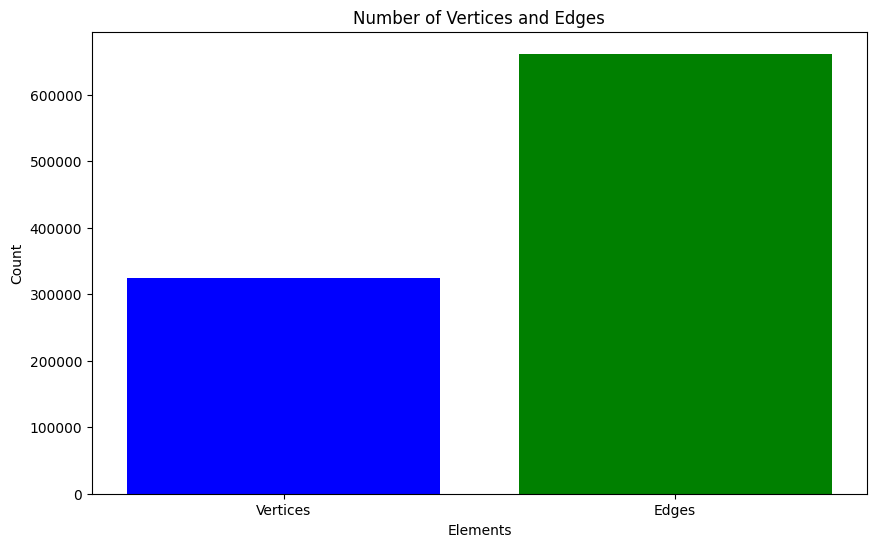

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Count the number of vertices and edges
num_vertices = g.vertices.count()
num_edges = g.edges.count()

# Create a DataFrame with the counts
df = pd.DataFrame({'Elements': ['Vertices', 'Edges'], 'Count': [num_vertices, num_edges]})

# Plot the counts
plt.figure(figsize=(10, 6))
plt.bar(df['Elements'], df['Count'], color=['blue', 'green'])
plt.title('Number of Vertices and Edges')
plt.xlabel('Elements')
plt.ylabel('Count')
plt.show()